# 2-parameters discriminant analysis

Python notebook for constructing a Fisher disciminant from two 2D Gaussianly distributed correlated variables. The notebook creates artificial random data for two different types of processes, and the goal is then to separate these by constructing a Fisher discriminant.

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 30-12-2022 (latest update)

### References:
- Glen Cowan, Statistical Data Analysis, pages 51-57
- http://en.wikipedia.org/wiki/Linear_discriminant_analysis

***

In [31]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
from numpy.linalg import inv
from scipy import stats

In [2]:
r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)
save_plots = False          # For now, don't save plots (once you trust your code, switch on)

### Functions:

Function to calculate the separation betweem two lists of numbers (see equation at the bottom of the script).

__Note__: You need to fill in this function! 

In [29]:
def calc_separation(x, y):
    mean_x = np.mean(x, axis=0)
    std_x = np.std(x, axis=0)
    mean_y = np.mean(y, axis=0)
    std_y = np.std(y, axis=0)
    d = (mean_x - mean_y) / np.sqrt(std_x**2 + std_y**2)
    
    
    
    return np.abs(d)

## Define parameters:


Number of species, their means and widths, correlations and the number of observations of each species:

In [4]:
# Number of 'species': signal / background
n_spec = 2       

# Species A, mean and width for the two dimensions/parameters
mean_A  = [15.0, 50.0] 
width_A = [ 2.0,  6.0] 

# Species B, mean and width for the two dimensions/parameters
mean_B  = [12.0, 55.0] 
width_B = [ 3.0,  6.0] 

# Coefficient of correlation
corr_A = 0.8
corr_B = 0.9

# Amount of data you want to create
n_data = 2000         

## Generate data:

For each "species", produce a number of $(x_0,x_1)$ points which are (linearly) correlated:

In [5]:
# The desired covariance matrix.
V_A = np.array([[width_A[0]**2, width_A[0]*width_A[1]*corr_A],
                [width_A[0]*width_A[1]*corr_A, width_A[1]**2]])
V_B = np.array([[width_B[0]**2, width_B[0]*width_B[1]*corr_B],
                [width_B[0]*width_B[1]*corr_B, width_B[1]**2]])

# Generate the random samples.
spec_A = np.random.multivariate_normal(mean_A, V_A, size=n_data)
spec_B = np.random.multivariate_normal(mean_B, V_B, size=n_data)

***

## Plot your generated data:

We plot the 2D-data as 1D-histograms (basically projections) in $x_0$ and $x_1$:

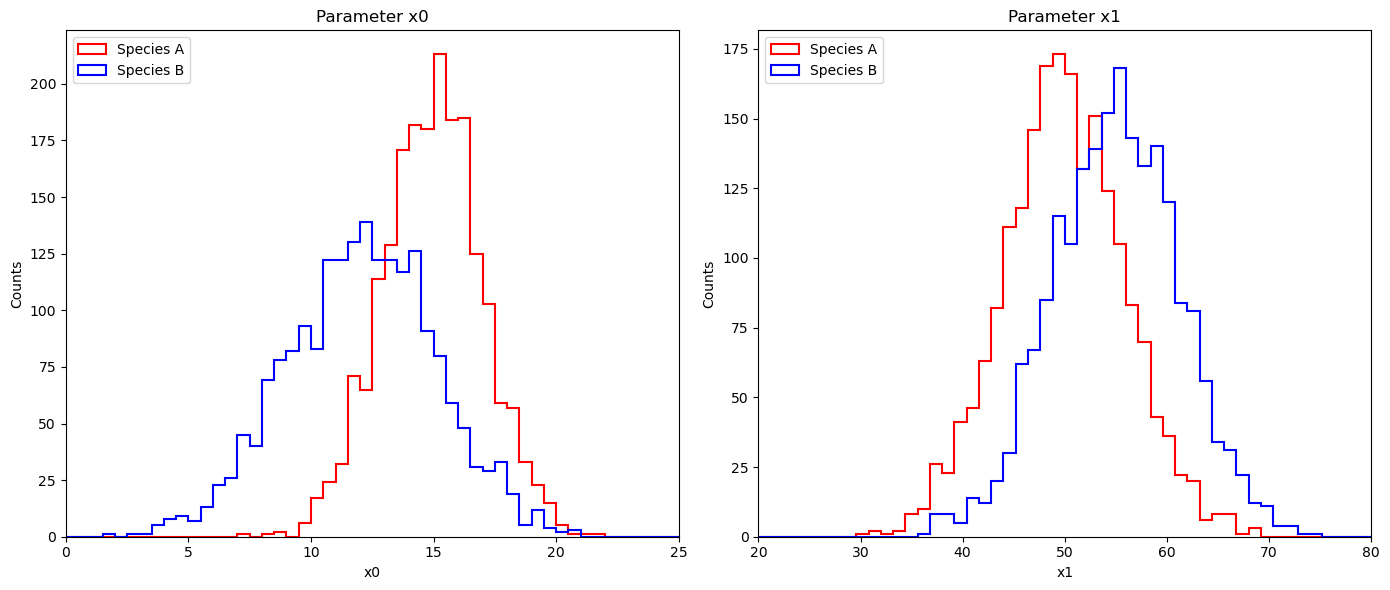

In [6]:
fig_1D, ax_1D = plt.subplots(ncols=2, figsize=(14, 6))

ax_1D[0].hist(spec_A[:, 0], 50, (0, 25), histtype='step', label='Species A', color='Red', lw=1.5)
ax_1D[0].hist(spec_B[:, 0], 50, (0, 25), histtype='step', label='Species B', color='Blue', lw=1.5)
ax_1D[0].set(title='Parameter x0', xlabel='x0', ylabel='Counts', xlim=(0,25))
ax_1D[0].legend(loc='upper left')

# uncomment later
#ax_1D[0].text(1, 176, fr'$\Delta_{{x0}} = {calc_separation(spec_A[:, 0], spec_B[:, 0]):.3f}$', fontsize=16)

ax_1D[1].hist(spec_A[:, 1], 50, (20, 80), histtype='step', label='Species A', color='Red', lw=1.5)
ax_1D[1].hist(spec_B[:, 1], 50, (20, 80), histtype='step', label='Species B', color='Blue', lw=1.5)
ax_1D[1].set(title='Parameter x1', xlabel='x1', ylabel='Counts', xlim=(20, 80))
ax_1D[1].legend(loc='upper left')

# uncomment later
#ax_1D[1].text(22, 140, fr'$\Delta_{{x1}} = {calc_separation(spec_A[:, 1], spec_B[:, 1]):.3f}$', fontsize=16)

fig_1D.tight_layout()

if save_plots :
    fig_1D.savefig('InputVars_1D.pdf', dpi=600)

NOTE: Wait with drawing the 2D distribution, so that you think about the 1D distributions first!

***

From the two 1D figures, it seems that species A and B can be separated to some degree, but not very well. If you were to somehow select cases of species A, then I can imagine a selection as follows:
 - If (x0 > 16) or (x1 < 46) or (x0 > 13 and x1 < 52), then guess / select as A.

Think about this yourself, and discuss with your peers, how you would go about separating A from B based on x0 and x1.

 -----------------------  5-10 minutes later  -----------------------
 
As it is, this type of selection is hard to optimise, especially with more dimensions (i.e. more variables than just x0 and x1). That is why Fisher's linear discriminant, $F$, is very useful. It makes the most separating linear combination of the input variables, and the coefficients can be calculated analytically. Thus, it is fast, efficient, and transparent. And it takes linear correlations into account.

In [7]:
# fig_corr, ax_corr = plt.subplots(figsize=(14, 8))

# ax_corr.scatter(spec_A[:, 0], spec_A[:, 1], color='Red',  s=10, label='Species A')
# ax_corr.scatter(spec_B[:, 0], spec_B[:, 1], color='Blue', s=10, label='Species B')
# ax_corr.set(xlabel='Parameter x0', ylabel='Parameter x1', title='Correlation');

# ax_corr.legend();
# fig_corr.tight_layout()

#if save_plots :
#    fig_corr.savefig('InputVars_2D.pdf', dpi=600)

## Fisher Discriminant calculation:

We want to find $\vec{w}$ defined by:

$$\vec{w} = \left(\Sigma_A + \Sigma_B\right)^{-1} \left(\vec{\mu}_A - \vec{\mu}_B\right)$$  

which we use to project our data into the best separating plane (line in this case) given by:

$$ \mathcal{F} = w_0 + \vec{w} \cdot \vec{x} $$

We start by finding the means and covariance of the individuel species: (__fill in yourself!__)

In [15]:
mu_A = np.mean(spec_A, axis=0)
mu_B = np.mean(spec_B, axis=0)
mu_A

array([14.95079563, 49.94147021])

In [16]:
cov_A = np.cov(spec_A, rowvar=False)
cov_B = np.cov(spec_B, rowvar=False)

In [17]:
cov_sum = cov_A + cov_B
cov_sum

array([[13.13960443, 26.0694801 ],
       [26.0694801 , 72.43074149]])

where `cov_sum` is the sum of the all of the species' covariance matrices. We invert this using scipy's `inv` function.  __Note__: fill in yourself!

In [18]:
# Inverts cov_sum
cov_sum_inv = inv(cov_sum)
cov_sum_inv

array([[ 0.26619799, -0.09581074],
       [-0.09581074,  0.04829077]])

We calculate the fisher weights, $\vec{w}$. __Note__: fill in yourself:

In [19]:
wf = cov_sum_inv @ (mu_A - mu_B)
wf

array([ 1.25431537, -0.5218836 ])

We calculate the fisher discriminant, $\mathcal{F}$. __Note__: fill in yourself:

In [24]:
fisher_data_A = wf @ spec_A.T 
fisher_data_B = wf @ spec_B.T 

and plot it:

Fisher separation: 2.505
corresponding p-value: 0.012


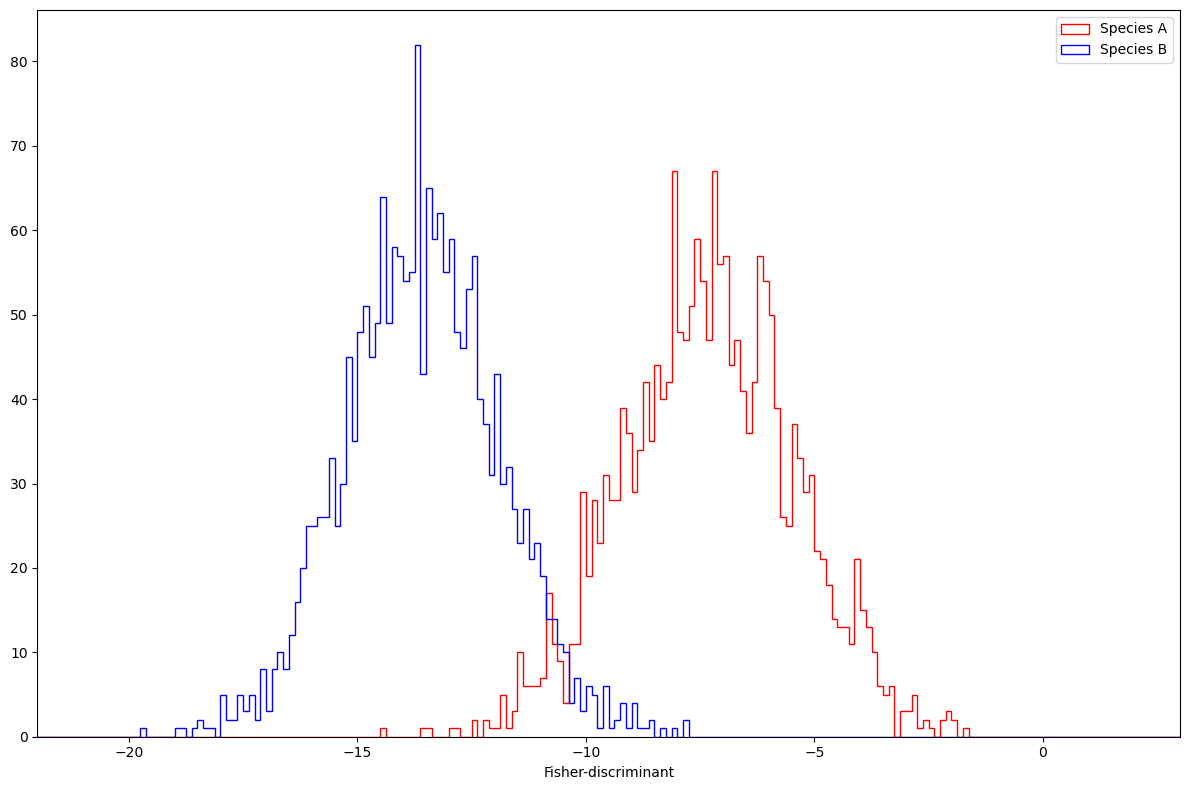

In [32]:
fig_fisher, ax_fisher = plt.subplots(figsize=(12, 8))
ax_fisher.hist(fisher_data_A, 200, (-22, 3), histtype='step', color='Red', label='Species A')
ax_fisher.hist(fisher_data_B, 200, (-22, 3), histtype='step', color='Blue', label='Species B')
ax_fisher.set(xlim=(-22, 3), xlabel='Fisher-discriminant')
ax_fisher.legend()

# ax_fisher.text(-21, 60, fr'$\Delta_{{fisher}} = {calc_separation(fisher_data_A, fisher_data_B):.3f}$', fontsize=16)

fig_fisher.tight_layout()

print(f'Fisher separation: {calc_separation(fisher_data_A, fisher_data_B):.3f}')
print(f'corresponding p-value: {2*stats.norm.sf(calc_separation(fisher_data_A, fisher_data_B)):.3f}')


if save_plots:
    fig_fisher.savefig('FisherOutput.pdf', dpi=600)

It is easy to visually see the increased seperation (when done correctly). We can also compare $\Delta_{fisher}$ to $\Delta_{x0}$ or $\Delta_{x1}$ and see it clearly.

# Questions

As always, make sure that you know what the code is doing so far, and what the aim of the exercise is (i.e. which problem to solve, and how). Then start to expand on it. 

1. Look at the 1D distributions of the two discriminating variables for the two species, and see how well you can separate them by eye. It seems somewhat possible, but certainly far from perfect... Once you consider the 2D distribution (scatter plot - to be uncommented by you!), then it is clear, that some cut along a line at an angle will work much better. This exercise is about finding that optimal line, and thus the perpendicular axis to project the data onto!

2. Calculate from the data the mean, widths (std) and covariance of each discriminating variable (pair of variables for covariance) for each species, and put these into the matrices defined.

3. From the inverted summed covariance matrices and vectors of means, calculate the two Fisher coefficients, and given these, calculate the Fisher discriminant for the two species in question, i.e. $ \mathcal{F} = \vec{w} \cdot \vec{x} = w_x \cdot x + w_y \cdot y $ for each point (x,y).

4. What separation did you get, and is it notably better than what you obtain by eye? Also, do your weights make sense? I.e. are they comparable to the widths of the
   corresponding variable? As a simple measure of how good the separation obtained is, we consider the "distance" $\Delta$ between the two distributions as a measure of goodness:  
   
   $$\Delta = \frac{|\mu_A-\mu_B|}{\sqrt{\sigma_A^2+\sigma_B^2}}$$
   
Compare the separation you get from each of the two 1D histograms of $x_0$ and $x_1$ with what you get from the Fisher discriminant, using the above formula. Of course the ultimate comparison should be done using ROC curves!

# Learning points:

This example should constitute the simplest use of the (Fisher) Linear Discriminant Analysis (LDA), where one separates two species through the (optimal) linear combination of two input variables. The weights can be calculated analytically, thus this method works fast and i (very) high dimensionality (10000+ dim).

You should be able to calculate the Fisher coefficients/weights, and know how to combine these with the input variables to get a good linear (Fisher) discriminator.

Another advantage of the Fisher is, that it is transparent! You can simply write up the expression you use.